# Xgboost Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

clean_research_practice1_version.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports


In [1]:
# %%capture
# # Import helper functions
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/image_processing.py

In [6]:
import os
import errno

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.tree import DecisionTreeClassifier

from file_management import bring_data, walk_through_dir, copy_folder
from image_processing import (center_image_IDG, get_visual_dictionary, 
                              get_histogram, applypca, applynmf)
from evaluation_functions import (hyperparametertunning, multiple_model_hyperparameter_tuning, 
                                  learningcurve, plotlearningcurve, multiclass_CV, 
                                  print_wrong_predictions, get_sub_model_predictions,
                                  get_multiple_model_predictions)

import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# Preprocessing

## Load the Data

In [12]:
# Bring data
df_BoF = pd.read_csv('data/BoF_probabilities.csv', index_col=0)
y = df_BoF.iloc[:,-1]
df_BoF = df_BoF.iloc[:,:-1]
df_BoF_pca = pd.read_csv('data/BoF-PCA_probabilities.csv', index_col=0).iloc[:,:-1]
df_BoF_pca80 = pd.read_csv('data/BoF-PCA80_probabilities.csv', index_col=0).iloc[:,:-1]
df_BoF_nmf = pd.read_csv('data/BoF-NMF_probabilities.csv', index_col=0).iloc[:,:-1]

X_dict = {'BoF': df_BoF, 'BoF-PCA': df_BoF_pca, 'BoF-PCA80': df_BoF_pca80, 'BoF-NMF': df_BoF_nmf}

# Model Evaluation

## Experiment Setting

In [13]:
# Create Directory
root = 'experiments/'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'BoF':df_BoF,'BoF-PCA':df_BoF_pca,'BoF-PCA80':df_BoF_pca80,'BoF-NMF':df_BoF_nmf}

Directory already exist
Type Experiment Name: first_XGBoost_experiment
Type Model Name: XGBoost


## Hyperparameter Tuning

In [15]:
%%capture

# Classifier - XGBoost
model = xgb.XGBClassifier(objective='multi:softmax')
hyperparameters = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'f1_macro')

## Learning Curves

In [17]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y, 
                                        5, param_dict, 'f1_macro', 
                                        np.linspace(0.1,1,50))

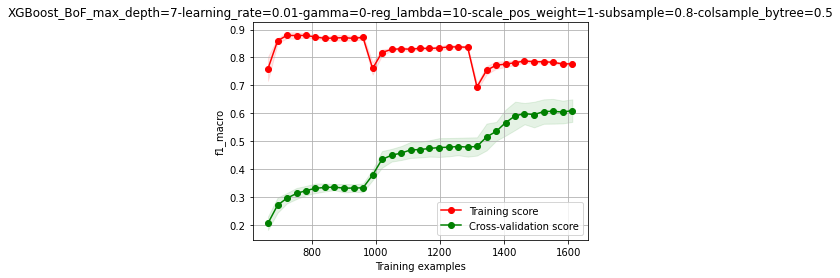

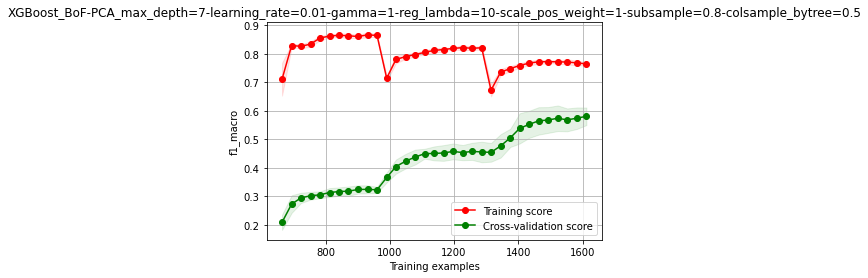

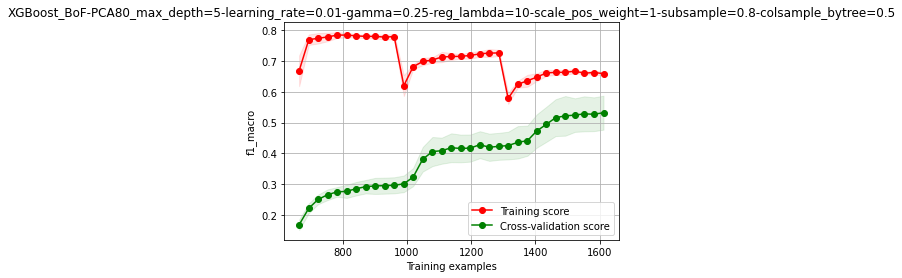

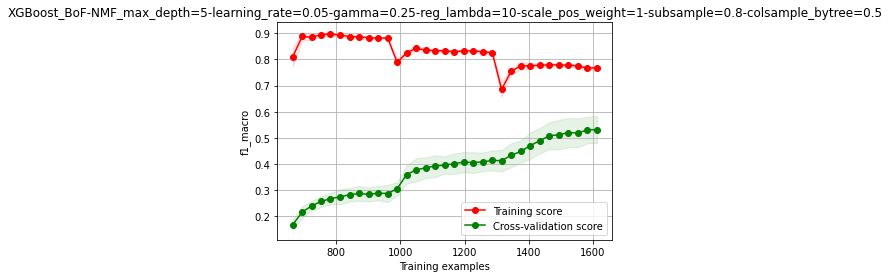

In [18]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'f1_macro', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

## Evaluating Performance Across Classes

In [21]:
CLASSES = ['carboard', 'glass', 'metal', 'paper', 'plastic']

df, model_wrong_preds = multiclass_CV(model, 5, X_dict, y, param_dict, 
                                      param_title_dictionary, CLASSES, 
                                      model_name, path, image_filenames)

NameError: name 'image_filenames' is not defined

[21:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

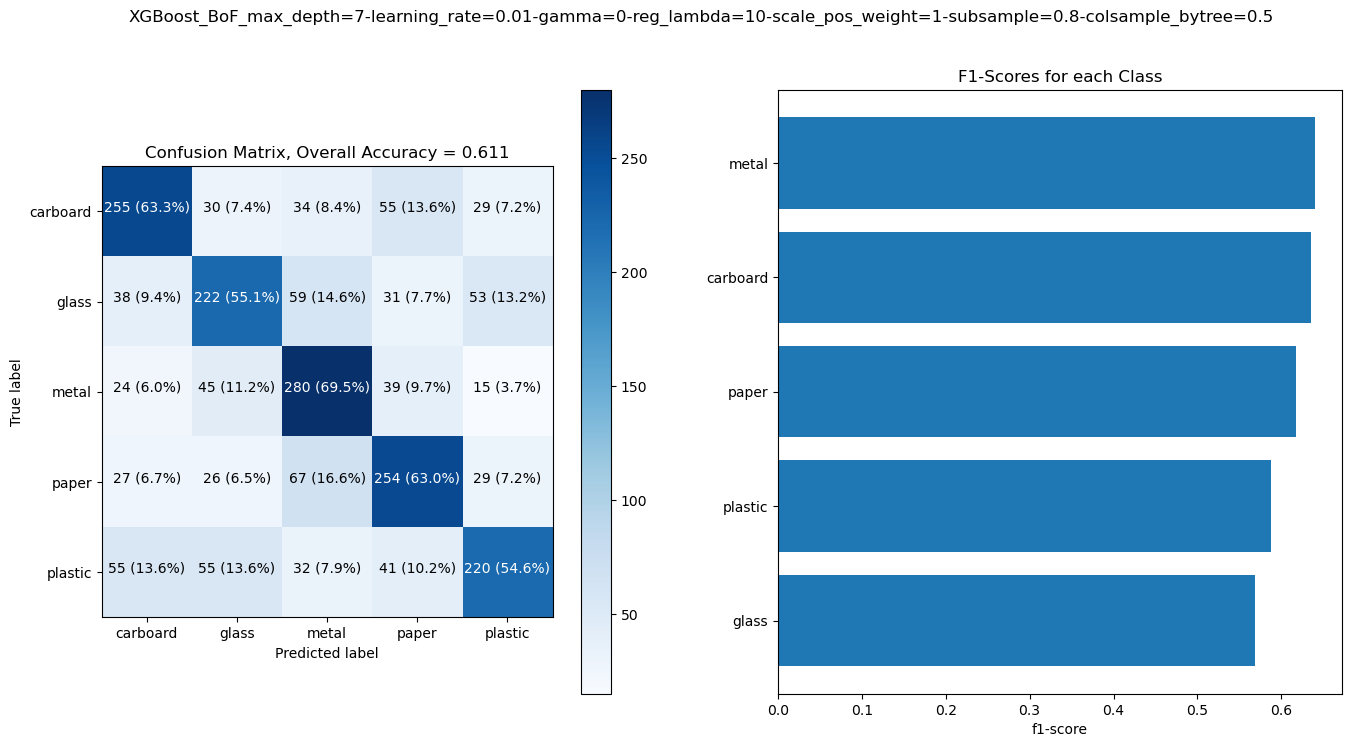

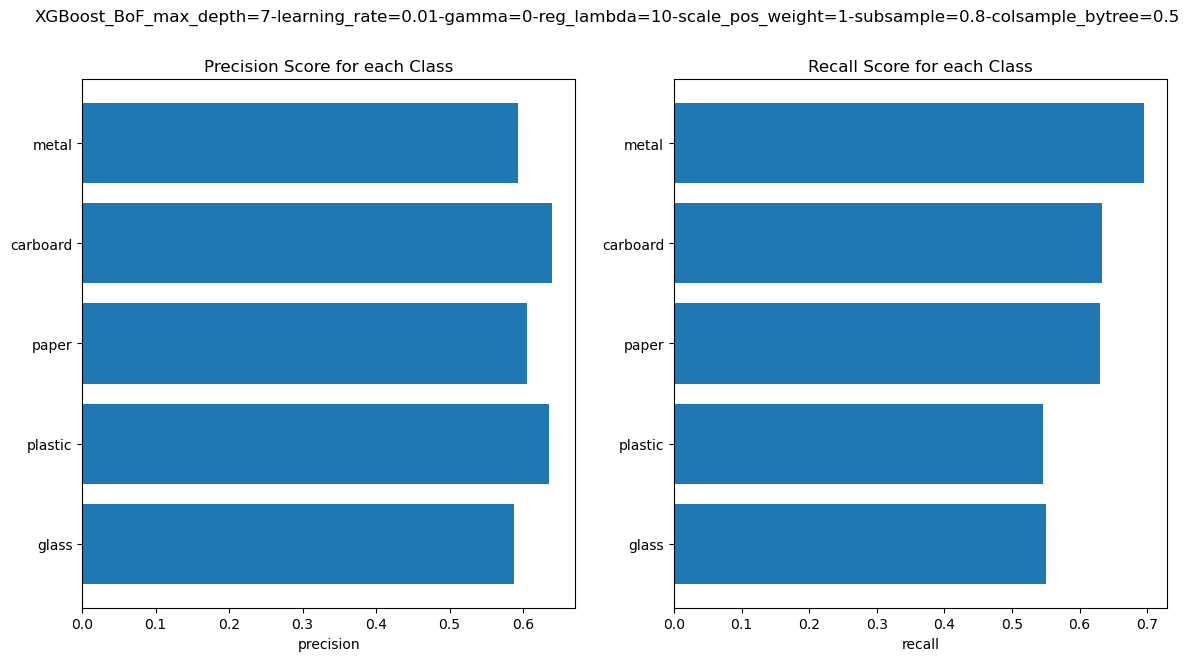

[21:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

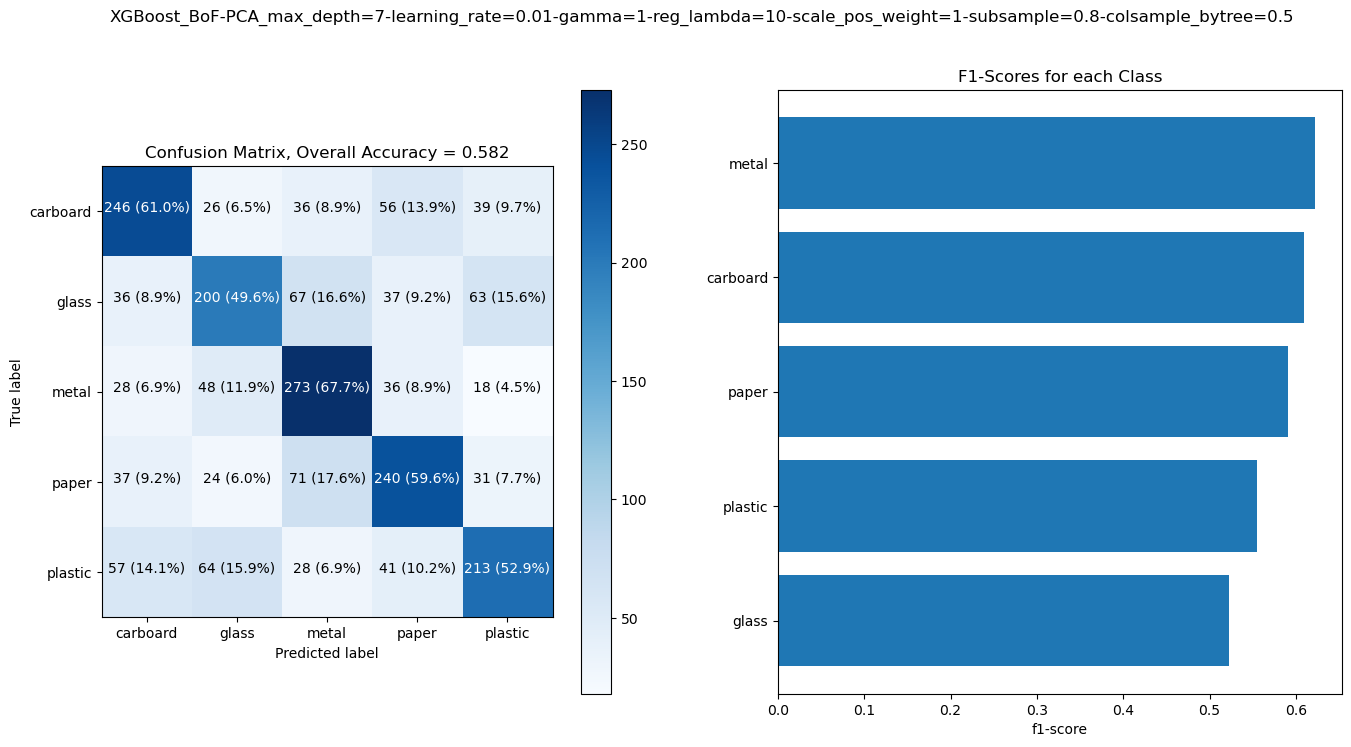

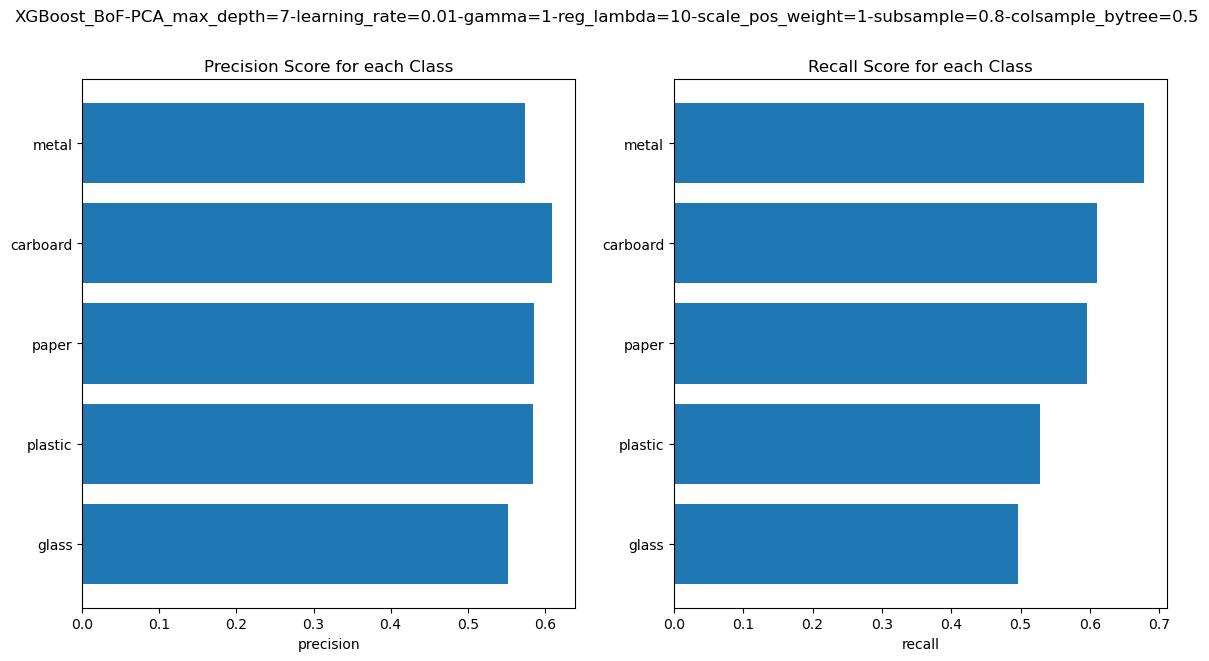

[21:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

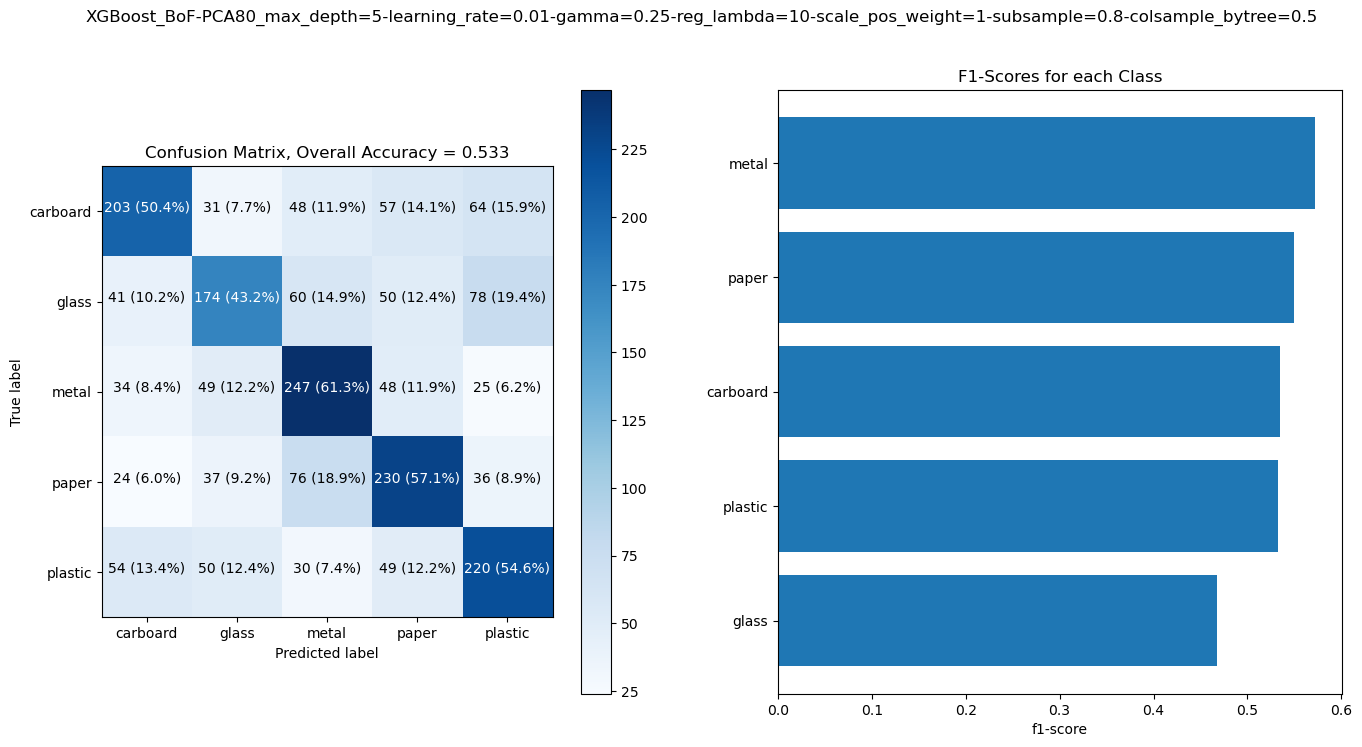

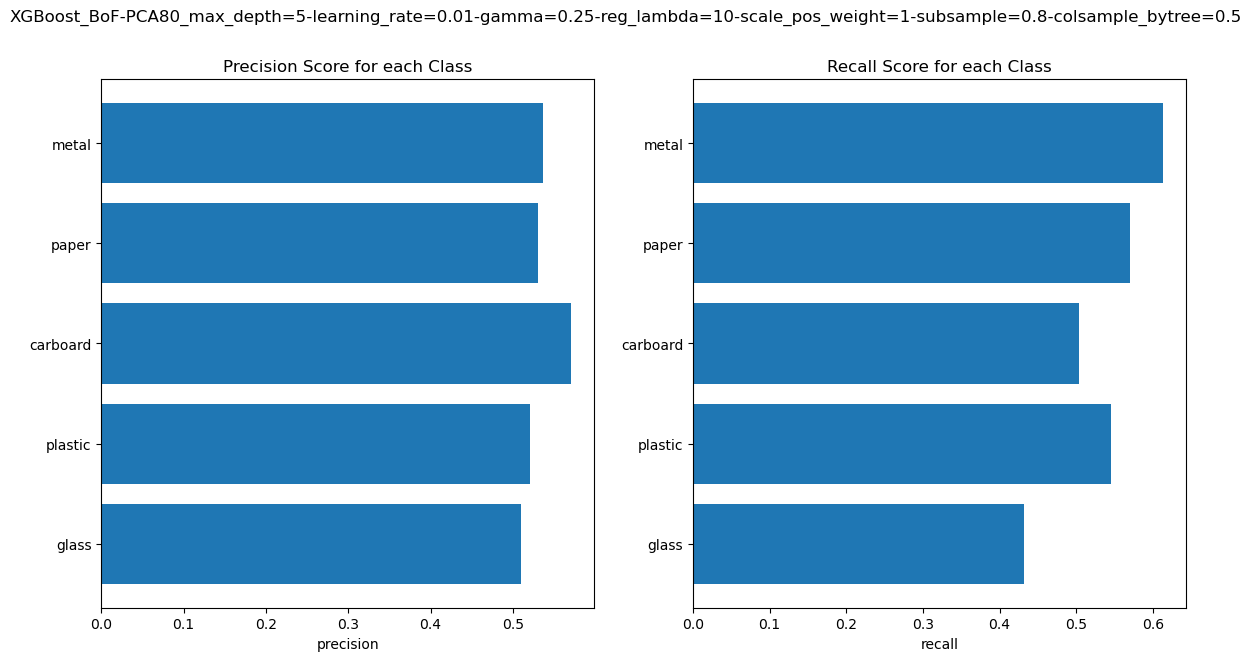

[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluatio

C:\Users\danie\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mist

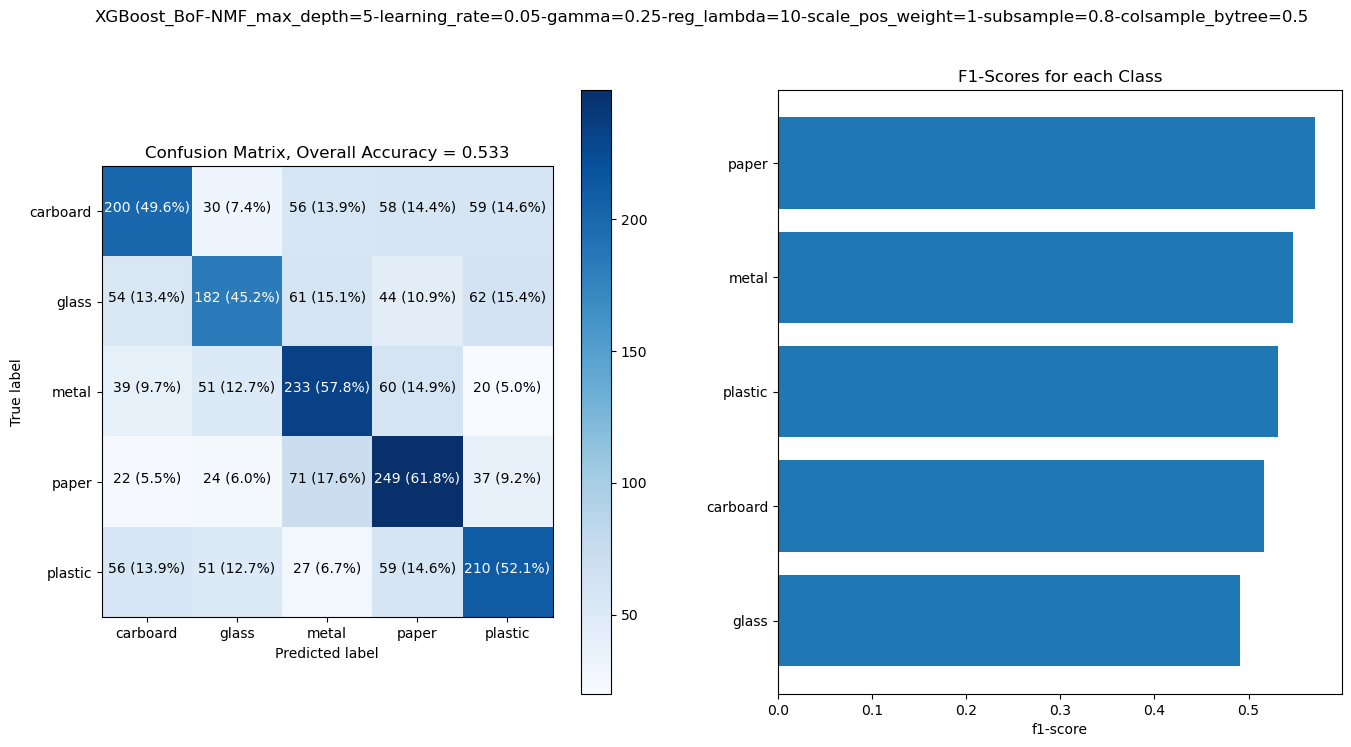

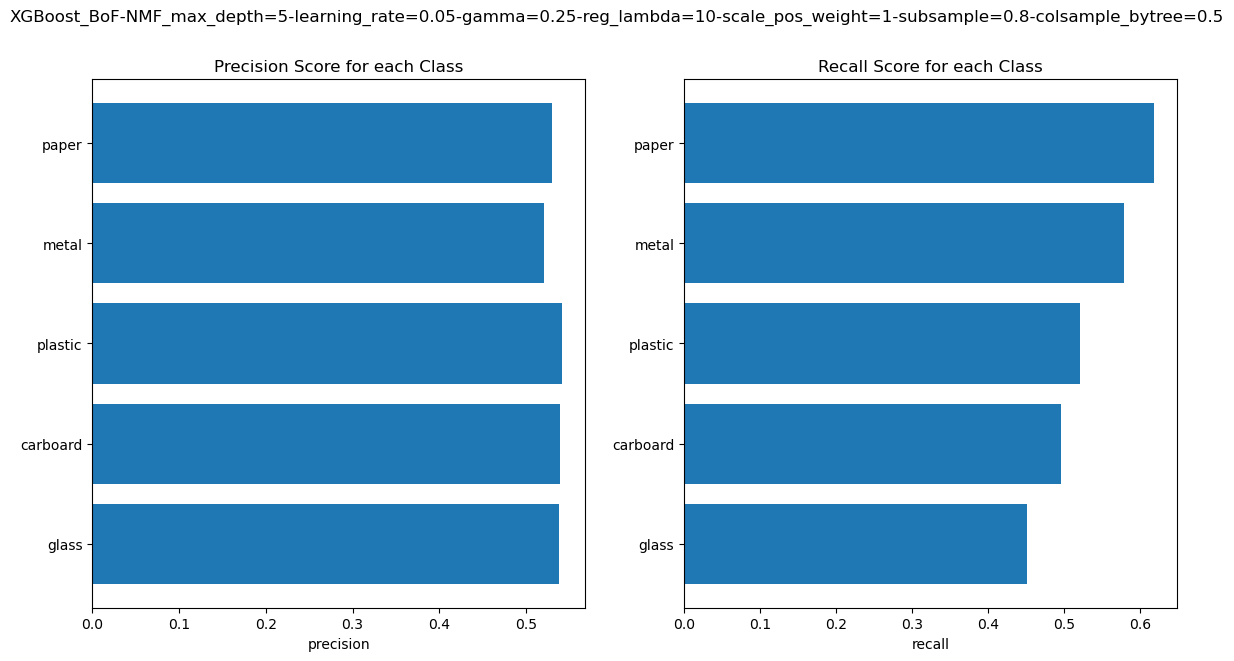

In [30]:
from sklearn.model_selection import StratifiedKFold
from evaluation_functions import across_class_results, make_confusion_matrix, precision_recall_barplot

df = pd.DataFrame()

classifier = model
k = 5
class_names = CLASSES

for dataset_key in X_dict.keys():

    X = X_dict[dataset_key].to_numpy()

    # Set parameters
    classifier.set_params(**param_dict[dataset_key])

    # Experiment Title
    title = model_name + '_' + dataset_key + '_' + \
                                        param_title_dictionary[dataset_key]

    skf = StratifiedKFold(n_splits=k)

    pred_labels = []
    true_labels = []
    test_indexes = []
    prob_labels = []

    for train_index, test_index in skf.split(X, y):

        # Split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model and predict
        classifier.fit(X_train, y_train)
        pred_probs = classifier.predict_proba(X_test)
        y_pred = pred_probs.argmax(axis=1)
        y_prob = pred_probs.max(axis=1)

        # Make confusion matrix
        pred_labels.extend(y_pred)
        true_labels.extend(y_test)
        test_indexes.extend(test_index)
        prob_labels.extend(y_prob)

    # Find most wrong predictions
#     model_wrong_preds[dataset_key] = find_most_wrong_prediction(image_filenames, 
#                                         test_indexes, true_labels, pred_labels, 
#                                         prob_labels, class_names, title, path)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8), dpi=100)

    class_scores, accuracy, df_results = across_class_results(true_labels, 
                                                pred_labels, class_names,
                                                title, fig, ax[1])
    make_confusion_matrix(true_labels, pred_labels, fig, ax[0], accuracy,
                           class_names, norm=True)
    fig.suptitle(title)

    # Save Figure
    filename = 'cv_' + str(title) + '.jpg'
    fig.savefig(os.path.join(path,filename), dpi = 100)
    plt.show()

    # Make Second Plot
    precision_recall_barplot(class_scores, title, path)

    # Create and Store DataFrame
    df = pd.concat([df, df_results], ignore_index=True, axis=0)
    df.to_csv(os.path.join(path,os.path.basename(path) + '.csv'))

## Store Datasets

In [72]:
data_root = 'data/'

for dataset_key in new_X_dict.keys():
    
    X = new_X_dict[dataset_key].to_numpy()
    df = pd.DataFrame(np.hstack((X,np.expand_dims(y, axis=1))))
    csv_name = dataset_key + '_probabilities.csv'
    df.to_csv(os.path.join(data_root, csv_name))

## Print Most Wrong Prediction

In [ ]:
print_wrong_predictions(model_wrong_preds['BoF'], 10, image_generator, params)